In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
Width = 256
Height = 256
K = 20

category = ['Aeroplanes', 'Bicycles', 'Birds', 'Boats', 'Bottles', 
            'Buses', 'Cars', 'Cats', 'Chairs', 'Cows', 
            'Dining tables', 'Dogs', 'Horses', 'Motorbikes', 'People',
            'Potted plants', 'Sheep', 'Sofas',  'Trains', 'TV/Monitors']

In [4]:
from torchvision import datasets, transforms
from PIL import Image, ImageEnhance

class VOCSegmentationAug(datasets.VOCSegmentation):
    def __init__(self, root, year, image_set, download, transform, target_transform):
        super().__init__(root, year, image_set, download, transform, target_transform)
        self.transform = transforms.Compose([transforms.Resize((Height, Width)),
                                             transforms.ToTensor()])
    def _brightness(self, x, y):
        p = np.random.uniform(0.5, 1.5)
        enhancer = ImageEnhance.Brightness(x)
        x = enhancer.enhance(p)
        
        return x, y
    
    def _contrast(self, x, y):
        p = np.random.uniform(0.5, 1.5)
        enhancer = ImageEnhance.Contrast(x)
        x = enhancer.enhance(p)
        
        return x, y
    
    def _sharpness(self, x, y):
        p = np.random.uniform(0.5, 1.5)
        enhancer = ImageEnhance.Sharpness(x)
        x = enhancer.enhance(p)
        
        return x, y
    
    def _color(self, x, y):
        p = np.random.uniform(0.5, 1.5)
        enhancer = ImageEnhance.Color(x)
        x = enhancer.enhance(p)
        
        return x, y
    
    def _rotate(self, x, y):
        rotate = np.random.randint(-90, 90)
        return x.rotate(rotate), y.rotate(rotate)
    
    def _flip(self, x, y):
        p = np.random.uniform(0, 1)
        if p < 0.5:
            return x.transpose(Image.FLIP_TOP_BOTTOM), y.transpose(Image.FLIP_TOP_BOTTOM) 
        else:
            return x, y
        
    def _mirror(self, x, y):
        p = np.random.uniform(0, 1)
        if p < 0.5:
            return x.transpose(Image.FLIP_LEFT_RIGHT), y.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            return x, y
    
    def _transform(self, x, y):
        return self.transform(x), self.transform(y)
        
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        x, y = self._brightness(x, y)
        x, y = self._contrast(x, y)
        x, y = self._sharpness(x, y)
        x, y = self._color(x, y)
        
        x, y = self._rotate(x, y)
        x, y = self._flip(x, y)
        x, y = self._mirror(x, y)
        x, y = self._transform(x, y)
        y = (y * 255).long()[0]
        
        return x, y
    
class VOCSegmentation(datasets.VOCSegmentation):
    def __init__(self, root, year, image_set, download, transform, target_transform):
        super().__init__(root, year, image_set, download, transform, target_transform)
        self.transform = transforms.Compose([transforms.Resize((Height, Width)),
                                             transforms.ToTensor()])
    
    def _transform(self, x, y):
        return self.transform(x), self.transform(y)
        
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        x, y = self._transform(x, y)
        y = (y * 255).long()[0]
        
        return x, y

                                   
train_data = VOCSegmentationAug(root='voc', year='2012', image_set='train', 
                               download=True, 
                               transform=None, 
                               target_transform=None)        

test_data = VOCSegmentation(root='voc', year='2012', image_set='val', 
                               download=True, 
                               transform=None, 
                               target_transform=None)

Using downloaded and verified file: voc/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: voc/VOCtrainval_11-May-2012.tar


In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, num_workers=1, shuffle=True)
print(train_loader)

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

In [7]:
dropout = 0.2

class DropoutConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
        super().__init__()
        #self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        
    def forward(self, x):
        x = self.conv(x)
        return x
            
class DownConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(DropoutConv2d(in_channels=in_channels, 
                                                        out_channels=hidden_channels, 
                                                        kernel_size=2, stride=2, bias=False),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),

                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=hidden_channels,
                                                        kernel_size=3, padding=1),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=hidden_channels,
                                                        kernel_size=3, padding=1),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        x = self.module_list[3](x)
        
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_channels, 
                                                                           kernel_size=2, stride=2, bias=False),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                         
                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                                      out_channels=hidden_channels,
                                                                      kernel_size=3, padding=1),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                                      out_channels=hidden_channels,
                                                                      kernel_size=3, padding=1),
                                                        nn.BatchNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        x = self.module_list[3](x)
        
        return x
        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Unet

        self.prenet = DropoutConv2d(in_channels=3, out_channels=8, kernel_size=1)
        
        self.downs = nn.ModuleList([DownConv(8, 32, 16),
                                    DownConv(16, 64, 32),
                                    DownConv(32, 128, 64),
                                    DownConv(64, 256, 128),
                                    DownConv(128, 512, 256)])
             
        self.ups = nn.ModuleList([UpConv(256, 512, 128),
                                  UpConv(256, 128, 64),
                                  UpConv(128, 64, 32),
                                  UpConv(64, 32, 16),
                                  UpConv(32, 64, 32)])
        
        self.postnet = DropoutConv2d(in_channels=32, out_channels=K, kernel_size=3, padding=1)
        
    def forward(self, x):
        # x : (b, c, h, w)
        
        xs = []
        # 1
        x = self.prenet(x)
        xs.append(x)
        # 1/2, 1/4, 1/8, 1/16
        for i, down in enumerate(self.downs):
            x = down(x)
            xs.append(x)
        
        x = None
        outputs = []
        for up in self.ups:
            if x is None:
                x = xs.pop()
            else:
                x = torch.cat([x, xs.pop()], dim=1)
            
            x = up(x)
        
        x = self.postnet(x)
        
        return x
    
print('done')

done


In [8]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/cityscape_uncertainty2'
#!rm -rf $save_dir
logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1597151401.scpark-X299-WU8	save_15000  save_29000
events.out.tfevents.1597151683.scpark-X299-WU8	save_16000  save_3000
events.out.tfevents.1597151740.scpark-X299-WU8	save_17000  save_30000
events.out.tfevents.1597157031.scpark-X299-WU8	save_18000  save_31000
events.out.tfevents.1597157097.scpark-X299-WU8	save_19000  save_32000
events.out.tfevents.1597159920.scpark-X299-WU8	save_2000   save_33000
events.out.tfevents.1597159983.scpark-X299-WU8	save_20000  save_34000
events.out.tfevents.1597160074.scpark-X299-WU8	save_21000  save_4000
save_0						save_22000  save_5000
save_1000					save_23000  save_6000
save_10000					save_24000  save_7000
save_11000					save_25000  save_8000
save_12000					save_26000  save_9000
save_13000					save_27000
save_14000					save_28000


Model size 48.8MiB
done


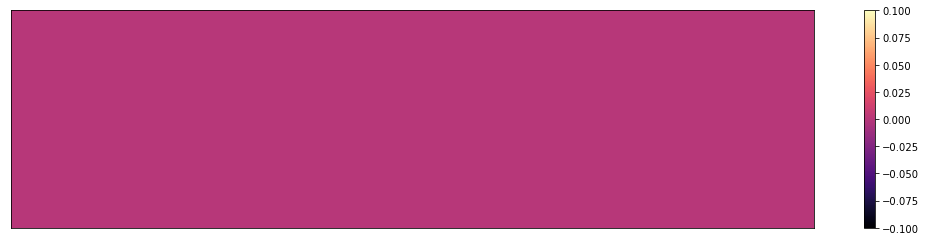

In [9]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time
import torch.distributed as dist

def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 0
GPU = 0

model = Unet()
model.cuda(GPU)

def sizeof_fmt(num, suffix='B'):
    """
    Given `num` bytes, return human readable size.
    Taken from https://stackoverflow.com/a/1094933
    """
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

path = get_save_path(save_dir, step)
if os.path.exists(path) and False:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')

print('done')

plt.figure(figsize=[18, 4])
librosa.display.specshow(np.zeros([100, 100]))
plt.colorbar()
plt.show()


1.Aeroplanes 2.Bicycles 3.Birds 4.Boats 5.Bottles 6.Buses 7.Cars 8.Cats 9.Chairs 10.Cows 11.Dining tables 12.Dogs 13.Horses 14.Motorbikes 15.People 16.Potted plants 17.Sheep 18.Sofas 19.Trains 20.TV/Monitors 


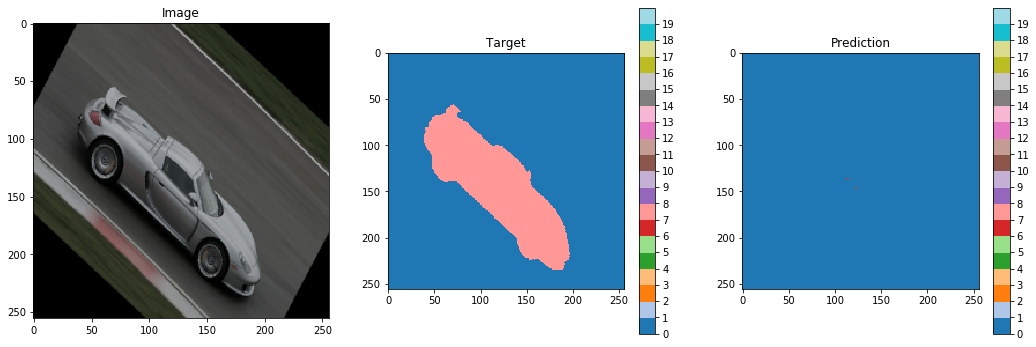

torch.Size([1, 20, 256, 256])


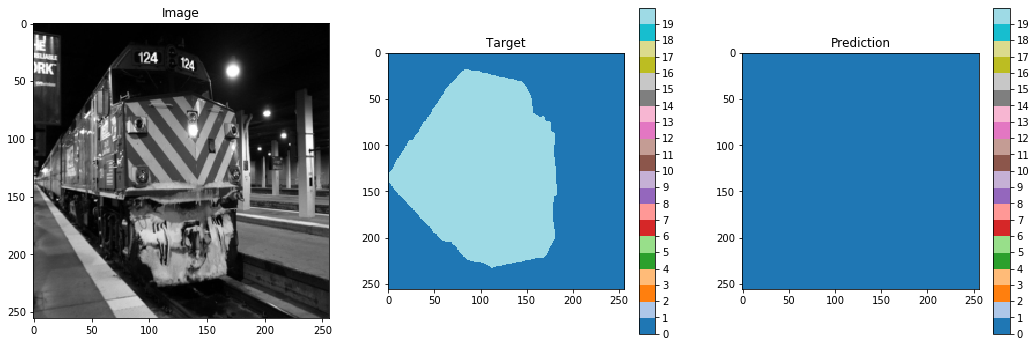

torch.Size([1, 20, 256, 256])


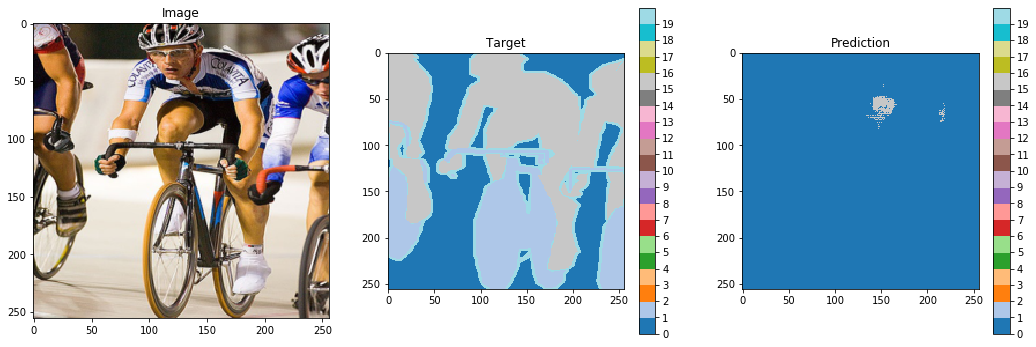

torch.Size([1, 20, 256, 256])


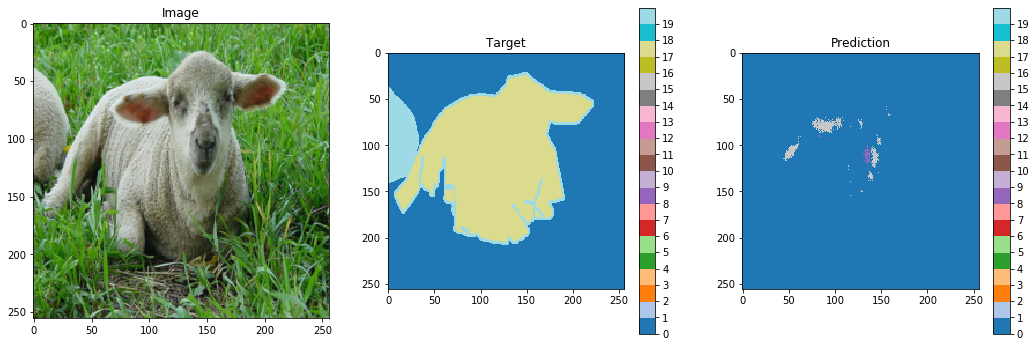

step: 1620 loss: 1.0238276720046997
step: 1640 loss: 0.9556515216827393
step: 1660 loss: 1.1917176246643066


KeyboardInterrupt: 

In [10]:
from IPython import display
import matplotlib.pyplot as plt

while(True):
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        y[torch.where(y==255)] = 0

        model.train()
        model.zero_grad()
        o = model(x)
        
        loss = nn.CrossEntropyLoss()(o, y)
        loss.backward()        
        optimizer.step()
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)
        
        if step % 20 == 0:
            print('step:', step, 'loss:', loss.item())
        
        if step % 100 == 0:
            display.clear_output()
            
            string = ''
            for index, cat in enumerate(category):
                string += str(index+1) + '.' + cat + ' '
            print(string)
            
            plt.figure(figsize=[18, 6])
            plt.subplot(1, 3, 1)
            plt.title('Image')
            _x = x[0].data.cpu().numpy()
            plt.imshow(_x.transpose(1, 2, 0))

            plt.subplot(1, 3, 2)
            plt.title('Target')
            _y = y[0].data.cpu().numpy()
            plt.imshow(_y, vmin=0, vmax=20, cmap='tab20')
            plt.colorbar(ticks=np.arange(0, 20))

            plt.subplot(1, 3, 3)
            plt.title('Prediction')
            _o = torch.argmax(o[0], dim=0)
            _o = _o.data.cpu().numpy()
            plt.imshow(_o, vmin=0, vmax=20, cmap='tab20')
            plt.colorbar(ticks=np.arange(0, 20))
            plt.show()
            
            for test_index in range(3, 6):
                x, y = test_data[test_index]
                x = x.cuda()[None]
                y = y[None]
                o = model(x)
                print(o.shape)

                plt.figure(figsize=[18, 6])
                plt.subplot(1, 3, 1)
                plt.title('Image')
                _x = x[0].data.cpu().numpy()
                plt.imshow(_x.transpose(1, 2, 0))

                plt.subplot(1, 3, 2)
                plt.title('Target')
                _y = y[0].data.numpy()
                plt.imshow(_y, vmin=0, vmax=20, cmap='tab20')
                plt.colorbar(ticks=np.arange(0, 20))

                plt.subplot(1, 3, 3)
                plt.title('Prediction')
                _o = torch.argmax(o[0], dim=0)
                _o = _o.data.cpu().numpy()
                plt.imshow(_o, vmin=0, vmax=20, cmap='tab20')
                plt.colorbar(ticks=np.arange(0, 20))
                plt.show()    

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
            
        step += 1
        

In [ ]:
print('done')